### **Imports and setup** 
Import packages, the config.py and architecture.py files and set global parameters

In [10]:
from config import (
    LEARNING_RATE,
    NUM_EPOCHS,
    TRAIN_SIZE,
    FP_BITS,
    FP_RADIUS,
    list_node_features,
    list_edge_features,
    BATCH_SIZE,
    NUM_ESTIMATORS,
    num_node_features,
    num_edge_features
)
from pkasolver.data import (
    load_data,
    preprocess_all,
    train_validation_set_split,
    make_stat_variables,
    make_pyg_dataset_based_on_number_of_hydrogens,
)
from pkasolver.ml_architecture import (
    GCN_pair,
    GCN_prot,
    GCN_deprot,
    NNConv_pair,
    NNConv_deprot,
    NNConv_prot,
    gcn_full_training,
)
from pkasolver.chem import generate_morgan_fp_array, calculate_tanimoto_coefficient
from pkasolver.ml import dataset_to_dataloader
import random

import numpy as np
import pandas as pd
import seaborn as sns
import copy
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6.25, 6.25)
sns.set_theme(style="ticks")

from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from IPython.display import display

import torch
from torch import optim
from rdkit.Chem import Draw

random.seed(SEED)
imgdir = "images_and_tables"
os.makedirs(imgdir, exist_ok=True)


## **Data Preprocessing**

#### **Import raw data**
Load data from sdf files, create conjugate molescules and store them in pandas DataFrames

Generating data ...
Training : ../../data/Baltruschat//combined_training_datasets_unique.sdf
###############
Novartis : ../../data/Baltruschat//novartis_cleaned_mono_unique_notraindata.sdf
###############
AvLiLuMoVe : ../../data/Baltruschat//AvLiLuMoVe_cleaned_mono_unique_notraindata.sdf
###############
dict_keys(['Training', 'Novartis', 'AvLiLuMoVe', 'train_split', 'val_split'])


,pKa,marvin_pKa,marvin_atom,marvin_pKa_type,original_dataset,ID,smiles,protonated,deprotonated
536,9.7,9.63,4,basic,['chembl25'],871123,CC(C)(C)[NH2+]CC(O)c1cc(Cl)c(N)c(C(F)(F)F)c1,,

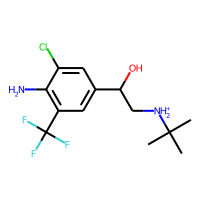
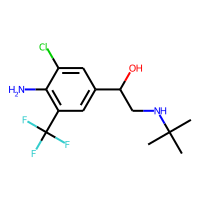

In [2]:
# make sure the directory for saving the run data exists
run_filename = "run_data2"
os.makedirs(f"{run_filename}/", exist_ok=True)

# check if saved dictonary of Dataframes is available and if so, import it
if os.path.isfile(f"{run_filename}/data_dfs.pkl"):
    print("Loading data ...")
    with open(f"{run_filename}/data_dfs.pkl", "rb") as pickle_file:
        dataset = pickle.load(pickle_file)

# create DataFrames for each dataset, store them in a dictonary and save it as as .pkl file in in the run_data folder
else:
    print("Generating data ...")
    sdf_paths = load_data("../../data/Baltruschat/")
    dataset = preprocess_all(sdf_paths)
    dataset["train_split"], dataset["val_split"] = train_validation_set_split(
        dataset["Training"], TRAIN_SIZE, SEED
    )

    with open(f"{run_filename}/data_dfs.pkl", "wb") as pickle_file:
        pickle.dump(dataset, pickle_file)

# notification
print(dataset.keys())
display(dataset["train_split"].head(1))



# **Calulate fingerprint based data**
Create Fingerprints, target-value objects and add best tanimoto similarities of fps form external validation set molecules with those of the train molecules

In [ ]:
# check if saved dictonary of fingerprint data is available and if so, import it
if os.path.isfile(f"{run_filename}/fp_data.pkl"):
    with open(f"{run_filename}/fp_data.pkl", "rb") as pickle_file:
        fp_data = pickle.load(pickle_file)


# create fingerprint arrays (dim: num molecules x fp bits) for each dataset, store them in a dictonary and save it as as .pkl file in in the run_data folder
else:
    fp_data = {}
    for name, df in dataset.items():
        X_feat, y = make_stat_variables(df, [], ["pKa"])
        X_prot = generate_morgan_fp_array(
            df, "protonated", nBits=FP_BITS, radius=FP_RADIUS, useFeatures=True
        )
        X_deprot = generate_morgan_fp_array(
            df, "deprotonated", nBits=FP_BITS, radius=FP_RADIUS, useFeatures=True
        )
        X = np.concatenate((X_prot, X_deprot), axis=1)
        fp_data[f"{name}"] = {"prot": X_prot, "deprot": X_deprot, "pair": X, "y": y}

    with open(f"{run_filename}/fp_data.pkl", "wb") as f:
        pickle.dump(fp_data, f)

    # add max tanimotosimilarity to the Dataframes of external test sets
    train_name = "train_split"
    val_name = "val_split"
    for name, dataset in fp_data.items():
        if name in [train_name, val_name]:
            pass
        else:
            print(f"calculating similarities for {name}")
            max_scores = []
            for test_mol in dataset["prot"]:
                scores = []
                for ref_mol in fp_data[train_name]["prot"]:
                    scores.append(calculate_tanimoto_coefficient(test_mol, ref_mol))
                max_scores.append(max(scores))
            dataset[name]["Similarity_max"] = max_scores

    with open(f"{run_filename}/data_dfs.pkl", "wb") as f:
        pickle.dump(dataset, f)

# notification
print("fp_data keys:", fp_data.keys())
print(f"calculated/loaded fingerprint data successfully")



# **Calculate graph data**
Create graph data with node and edge features specified in the config file and prepare loaders

In [3]:
# check if saved dictonary of graph data is available and if so, import it
if os.path.isfile(f"{run_filename}/graph_data.pkl"):
    print("Loading data ...")
    with open(f"{run_filename}/graph_data.pkl", "rb") as f:
        graph_data = pickle.load(f)

# create list of 'PairData' graph objects for each dataset, store them in a dictonary and save it as as .pkl file in in the run_data folder
else:
    print("Generating data ...")
    graph_data = {}
    for name, df in dataset.items():
        print(f"Generating data for: {name}")
        graph_data[name] = make_pyg_dataset_based_on_number_of_hydrogens(
            df, list_node_features, list_edge_features, paired=True
        )
    with open(f"{run_filename}/graph_data.pkl", "wb") as f:
        pickle.dump(graph_data, f)

print("graph_data keys:", graph_data.keys())

# create an iterable loader object from the list of graph data of each dataset and store them in a dictonary
loaders = {}
for name, dataset in graph_data.items():
    print(f"Generating loader for {name}")
    if name == "Training":
        print("Skipping unsplit Training dataset")
        continue
    loaders[name] = dataset_to_dataloader(dataset, BATCH_SIZE, shuffle=True)

# notification
print("loaders keys:", loaders.keys())
print(f"calculated/loaded graph data successfully")



Generating data ...
Generating data for: Training
Generating data with paired boolean set to: True
Generating data for: Novartis
Generating data with paired boolean set to: True
Generating data for: AvLiLuMoVe
Generating data with paired boolean set to: True
Generating data for: train_split
Generating data with paired boolean set to: True
Generating data for: val_split
Generating data with paired boolean set to: True
graph_data keys: dict_keys(['Training', 'Novartis', 'AvLiLuMoVe', 'train_split', 'val_split'])
Generating loader for Training
Skipping unsplit Training dataset
Generating loader for Novartis
Generating loader for AvLiLuMoVe
Generating loader for train_split
Generating loader for val_split
loaders keys: dict_keys(['Novartis', 'AvLiLuMoVe', 'train_split', 'val_split'])
calculated/loaded graph data successfully


In [ ]:
next(iter(loaders['train_split']))

**show feature value range**

In [ ]:
# print all possible node feature values
values = [set() for i in range(len(list_node_features))]
for dataset in graph_data.values():
    for entry in dataset:
        for i, row in enumerate(entry.x_p.cpu().T):
            values[i] = values[i] | set(row.numpy())
        for i, row in enumerate(entry.x_d.cpu().T):
            values[i] = values[i] | set(row.numpy())
print("Node features:")
for name, values in zip(list_node_features, values):
    x = list(values)
    x.sort()
    print(f"{name}:{x}")
print("\n")

# print all possible edge feature values
values = [set() for i in range(len(list_edge_features))]
for dataset in graph_data.values():
    for entry in dataset:
        for i, row in enumerate(entry.edge_attr_p.cpu().T):
            values[i] = values[i] | set(row.numpy())
        for i, row in enumerate(entry.edge_attr_d.cpu().T):
            values[i] = values[i] | set(row.numpy())
print("Edge features:")
for name, values in zip(list_edge_features, values):
    x = list(values)
    x.sort()
    print(f"{name}:{x}")



In [ ]:
next(iter(graph_data.values()))[0]

# **Training of predictive models**

## **train baseline models**
train all baseline models in protonated, deprotonated and pair mode

In [ ]:
models_dict = {
    "RFR": RandomForestRegressor(
        n_estimators=NUM_ESTIMATORS, random_state=SEED
    ),  # Baltruschat n_estimatores = 1000
    "PLS": PLSRegression(),
}

baseline_models = {}
train_name = "train_split"
val_name = "val_split"

for model_name, model_template in models_dict.items():
    baseline_models[model_name] = {}
    for mode, X in fp_data[train_name].items():
        if mode == "y":
            continue
        path = f"models/baseline/{model_name}/{mode}/"
        if os.path.isfile(path + "model.pkl"):
            with open(path + "model.pkl", "rb") as pickle_file:
                baseline_models[model_name][mode] = pickle.load(pickle_file)
        else:
            y = fp_data[train_name]["y"]
            y_val = fp_data[val_name]["y"]
            model = copy.deepcopy(model_template)
            model.fit(X, y)
            print(f"{model_name}_{mode}: {model.score(fp_data[val_name][mode], y_val)}")
            baseline_models[model_name][mode] = model
            os.makedirs(path, exist_ok=True)
            with open(path + "model.pkl", "wb") as pickle_file:
                pickle.dump(model, pickle_file)
print(f"trained/loaded baseline models successfully")



# **Train graph models**

## **Training**
train all graph models in protonated, deprotonated and pair mode

In [11]:
embedding_size = 96
num_graph_layer = 4
num_linear_layer = 2

gcn_dict = {
    "prot": {"no-edge": GCN_prot, "edge": NNConv_prot},
    "deprot": {"no-edge": GCN_deprot, "edge": NNConv_deprot},
    "pair": {"no-edge": GCN_pair, "edge": NNConv_pair},
}

mol_modes = ["prot", "deprot", "pair"]
edge_modes = ["no-edge", "edge"]

graph_models = {}
for mode in mol_modes:
    graph_models[mode] = {}
    for edge in edge_modes:
        path = f"models/gcn/{mode}/{edge}/"

        if os.path.isfile(path + "model.pkl"):
            with open(path + "model.pkl", "rb") as pickle_file:
                graph_models[mode][edge] = pickle.load(pickle_file)
            model = graph_models[mode][edge]
        else:
            model = gcn_dict[mode][edge](96, 4, 2, num_node_features, num_edge_features)
            graph_models[mode][edge] = model
            os.makedirs(path, exist_ok=True)

        if model.checkpoint["epoch"] < NUM_EPOCHS:
            print(model.checkpoint["epoch"])
            optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
            print("Number of parameters: ", sum(p.numel() for p in model.parameters()))            
            try:
                optimizer.load_state_dict(model.checkpoint["optimizer_state"])
            except:
                pass
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, patience=5, verbose=True
            )

            print(
                f'Training GCN_{mode} with {edge} at epoch {model.checkpoint["epoch"]}...'
            )
            print(model)
            print(f'Training on {DEVICE}.')
            gcn_full_training(
                model.to(device=DEVICE),
                loaders["train_split"],
                loaders["val_split"],
                optimizer,
                path,
                NUM_EPOCHS,
            )

            with open(path + "model.pkl", "wb") as pickle_file:
                pickle.dump(model, pickle_file)
print(f"trained/loaded gcn models successfully")

0
Number of parameters:  38209
Training GCN_prot with no-edge at epoch 0...
GCN_prot(
  (convs): ModuleList(
    (0): GCNConv(8, 96)
    (1): GCNConv(96, 96)
    (2): GCNConv(96, 96)
    (3): GCNConv(96, 96)
  )
  (lin): ModuleList(
    (0): Linear(in_features=96, out_features=96, bias=True)
    (1): Linear(in_features=96, out_features=1, bias=True)
  )
)
Training on cuda.
Epoch: 000, Train MAE: 6.7820, Test MAE: 6.9170
Epoch: 020, Train MAE: 1.7410, Test MAE: 1.7060
Epoch: 040, Train MAE: 1.3170, Test MAE: 1.3100
Epoch: 060, Train MAE: 1.0940, Test MAE: 1.1400
Epoch: 080, Train MAE: 0.8950, Test MAE: 0.9560
Epoch: 100, Train MAE: 0.9180, Test MAE: 0.9710
Epoch: 120, Train MAE: 0.8330, Test MAE: 0.9120
Epoch: 140, Train MAE: 0.8260, Test MAE: 0.9110
Epoch: 160, Train MAE: 0.8130, Test MAE: 0.9180
Epoch: 180, Train MAE: 0.7910, Test MAE: 0.9290
Epoch: 200, Train MAE: 0.7530, Test MAE: 0.8700
Epoch: 220, Train MAE: 0.7070, Test MAE: 0.8340
Epoch: 240, Train MAE: 0.7540, Test MAE: 0.8760


#### **Cross validation**

##### **prepare graph and fp data for cv**

In [ ]:
cv_graph_data = data.slice_list(graph_data['train_split']+graph_data['val_split'],5)
# cv_graph_train, cv_graph_val = data.cross_val_lists(cv_graph_data,run_cv)

cv_loaders={'train':{},'val':{}}
for i in range(5):
    train, val = data.cross_val_lists(cv_graph_data,i)
    cv_loaders['train'][i] = ml.dataset_to_dataloader(train, BATCH_SIZE)
    cv_loaders['val'][i] = ml.dataset_to_dataloader(val, BATCH_SIZE)

for name, nums in cv_loaders.items():
    for num, obj in nums.items(): 
        print('graph_data: ',name, num, obj)
        
#create dictionary with modes as keys and a list of 5 arrays for each value
cv_fp_data={}
for name, array in fp_data['train_split'].items():
    try:
        cv_fp_data[name]=np.vstack((array,fp_data['val_split'][name]))
    except:
        cv_fp_data[name]=np.hstack((array,fp_data['val_split'][name]))
for name, array in cv_fp_data.items():
    cv_fp_data[name] = data.slice_list(array,5)

#generate 
cv_fp_sets={'train':{},'val':{}}
for i in range(5):
    cv_fp_train={}
    cv_fp_val={}
    for name, array in cv_fp_data.items():
        train, val = data.cross_val_lists(array,i)
        cv_fp_train[name] = np.array(train, dtype=object)
        cv_fp_val[name] = np.array(val, dtype=object)
    cv_fp_sets['train'][i]=cv_fp_train
    cv_fp_sets['val'][i]=cv_fp_val
    
for name, nums in cv_fp_sets.items():
    for num, modes in nums.items():
        print('fp_data: ',name, num, modes.keys())

##### **load baseline and gcn models for cv**

In [ ]:
mol_modes=['prot','deprot','pair']
edge_modes=['no-edge','edge']
cv = list(range(5))

graph_models_cv = {}
for mode in mol_modes:
    graph_models_cv[mode] ={}
    for edge in edge_modes:
        graph_models_cv[mode][edge] = {}
        for num_cv in cv: 
            path = f'cv_models/gcn/{mode}/{edge}/{num_cv}/'
            if os.path.isfile(path+'model.pkl'):
                with open(path+'model.pkl', 'rb') as pickle_file:
                    graph_models_cv[mode][edge][num_cv] = pickle.load(pickle_file)
                model = graph_models_cv[mode][edge][num_cv]
            else:
                print(f'cv_models/gcn/{mode}/{edge}/{num_cv}/ not found')

baseline_models_cv = {}
for name in models_dict.keys():
    baseline_models_cv[name]={}
    for mode in mol_modes:
        baseline_models_cv[name][mode] ={}
        for num_cv in cv: 
            path = f'cv_models/baseline/{name}/{mode}/{num_cv}/'
            if os.path.isfile(path+'model.pkl'):
                with open(path+'model.pkl', 'rb') as pickle_file:
                    baseline_models_cv[name][mode][num_cv] = pickle.load(pickle_file)
            else:
                print(f'cv_models/baseline/{name}/{mode}/{num_cv}/ not found')
                
for name, modes in graph_models_cv.items():
    for mode in modes.keys():
        print('gcn: ',name, mode)
for name, modes in baseline_models_cv.items():
    for mode in modes.keys():
        print('baseline: ',name, mode)

**Load bestmodels**

In [ ]:
epoch_treshold = 2000

In [ ]:
mol_modes=['prot','deprot','pair']
edge_modes=['no-edge','edge']
cv = list(range(5))

graph_models_cv = {}
for mode in mol_modes:
    graph_models_cv[mode] ={}
    for edge in edge_modes:
        graph_models_cv[mode][edge] = {}
        for num_cv in cv: 
            path = f'cv_models/gcn/{mode}/{edge}/{num_cv}/'
            if os.path.isfile(path+'model.pkl'):
                with open(path+'model.pkl', 'rb') as pickle_file:
                    model = pickle.load(pickle_file)
                best_loss = max([x for x in model.checkpoint['best_states'].keys() if x < epoch_treshold]) 
                model.load_state_dict(model.checkpoint['best_states'][best_loss][1])
                loss = model.checkpoint['best_states'][best_loss][0]
                print(f'GCN_{mode}_{edge}_{num_cv},Epoch {best_loss}, Loss:{loss}')
                graph_models_cv[mode][edge][num_cv] = model
            else:
                print(f'{path} not found')
                

In [ ]:
graph_models = {}
for mode in mol_modes:
    graph_models[mode] ={}
    for edge in edge_modes:
        graph_models[mode][edge] = {} 
        path = f'models/gcn/{mode}/{edge}/'
        if os.path.isfile(path+'model.pkl'):
            with open(path+'model.pkl', 'rb') as pickle_file:
                model = pickle.load(pickle_file)
            best_loss = max([x for x in model.checkpoint['best_states'].keys() if x < epoch_treshold]) 
            model.load_state_dict(model.checkpoint['best_states'][best_loss][1])
            loss = model.checkpoint['best_states'][best_loss][0]
            print(f'GCN_{mode}_{edge},Epoch {best_loss}, Loss:{loss}')
            graph_models[mode][edge] = model
        else:
            print(f'{path} not found')

## **Results and Analysis**

#### **Test Baseline and Graph Models**
test the models and the valadation and the two external sets and store their predictions and the true valus in a DataFrame

In [ ]:
#Predictions of baseline and graph models

for i,test_set in enumerate(['Novartis','Literature','val_split']):
    df_ml = ml.test_ml_model(baseline_models, fp_data[test_set], fp_data[test_set]['y'],test_set)
    df_gcn = ml.test_graph_model(graph_models, loaders[test_set],test_set)
    df= pd.concat([df_ml,df_gcn.drop(columns=['Dataset', 'pKa_true'])],axis=1)
    if i == 0:
        df_res = df
    else:
        df_res = pd.concat([df_res,df])
display(df_res)

#### **Statistical metrics**
Calulate the Pearson Correlation Koefficient, the Root Mean Squared Error and the Mean absolute error of the validation and the two test sets for all models and list them in a DataFrame 

In [ ]:
test= stat.compute_stats(df_res, 'Dataset', 'pKa_true')
test.to_csv(f'{imgdir}/stat_metrics.csv')
display(test)

In [ ]:
test= stat.compute_stats(df_res, 'Dataset', 'pKa_true')
test.to_csv(f'{imgdir}/stat_metrics.csv')
display(test)

#### **CV results**
Load models

In [ ]:
cv_val_table= pd.concat((
    stat.cv_graph_model(graph_models_cv,cv_loaders['val']),
    stat.cv_ml_model(baseline_models_cv,cv_fp_sets['val'])
))
cv_val_table.to_csv(f'{imgdir}/cv_val_table.csv')
display(cv_val_table)

In [ ]:
d ={}
for data_set in ['Novartis','Literature']:
    d[data_set]= pd.concat([
    stat.cv_ml_model(baseline_models_cv,[fp_data[data_set] for i in range(5)]),
    stat.cv_graph_model(graph_models_cv,[loaders[data_set] for i in range(5)])
    ])
cv_test_table=pd.concat(d.values(), axis=1, keys=d.keys())
cv_test_table.to_csv(f'{imgdir}/cv_test_table.csv')
cv_test_table

#### **Plot best model**
Plot the predictions of the best models for the validation and the two testsets

In [ ]:
def plot_results(df, x_column, y_column):
    y = df[x_column]
    y_hat = df[y_column]
    stat_info = f"""
        $r^2$ = {r2_score(y, y_hat): .2f}
        $MAE$ = {mean_absolute_error(y, y_hat): .2f}
        $RMSE$ = {mean_squared_error(y, y_hat): .2f}
        """
        # r² = 0.78 [0.74, 0.81]
    g = sns.JointGrid(data=df, x=x_column, y=y_column, xlim=(2,12), ylim=(2,12), height=3.125)
    g.plot_joint(sns.regplot)
    g.plot_marginals(sns.kdeplot, shade=True)
    g.ax_joint.text(0, 1, stat_info, size='x-small', ha='left', va="top", transform = g.ax_joint.transAxes)
    return g

In [ ]:
sns.set_context('paper')
d = df_res
model='GCN_pair_edge'
for dataset in d['Dataset'].unique():
# for dataset, model in zip(['Novartis','Literature'],['GCN_pair_edge', 'GCN_deprot_no-edge']):
    print(dataset)
    g = plot_results(d[d['Dataset']== dataset], 'pKa_true', model)
    g.set_axis_labels('pKa (true)', 'gcn_pair_edge')
    plt.savefig(f'{imgdir}/regression_{dataset}_gcn_pair_edge.pdf', bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(3.125,3.125))
    sns.residplot(data=df_res[df_res['Dataset']==dataset],x='pKa_true', y=model, lowess=True)
    plt.ylabel('Error')
#     plt.title('gcn_pair_edge')
    plt.savefig(f'{imgdir}/residuals_{dataset}_gcn_pair_edge.pdf', bbox_inches='tight')

#### **GCN training progress**
store training losses in DataFrame and 

In [ ]:
for x,y in list([['pair','edge'],['prot','no-edge']]):
    df_prog=pd.DataFrame(graph_models[x][y].checkpoint['progress_table'])
#     df_prog=pd.DataFrame(graph_models_cv[x][y][1].checkpoint['progress_table'])
    #plot learning
    fig, ax = plt.subplots()
    fig.set_size_inches(3.125,3.125)
    sns.lineplot(x='epoch',y='train_loss', label='Train Loss',data=df_prog,ax=ax)
    sns.lineplot(x='epoch',y='test_loss',label='Validation Loss',data=df_prog,ax=ax)
    ax.set_ylabel("Loss (MAE)")
    ax.set_xlabel("Epoch")
    ax.set_xlim(left=0, right=2000)
    ax.set_ylim(top=1.75, bottom=0)
#     plt.title(f'training progress of gcn_{x}_{y} model')
    plt.savefig(f'{imgdir}/training_progress_gcn_{x}_{y}.pdf',bbox_inches='tight')
    plt.show()

#### **Feature impact**

**Importances of gcn_prot_edge'**

In [ ]:
def boxplot(attr_data):
    plt.figure(figsize=(3.125,6.25))
    sns.boxplot(x="value", y="variable",
                orient="h",
                data=attr_data,
                whis=[0, 100], width=.6)

    # Add in points to show each observation
    sns.stripplot(x="value", y="variable",
                orient="h",
                data=attr_data,
                size=4, color=".3", linewidth=0)
    plt.ylabel('')

types = ['prot','deprot','pair']
f_modes= ['no-edge','edge']
for data_type in types:
    for f_mode in f_modes: 
        model = graph_models[data_type][f_mode]
        dataset = graph_data['train_split']
        ig = IntegratedGradients(model)
        attr_pre_df = stat.calc_importances(ig, dataset, 100, NODE_FEATURES, EDGE_FEATURES) #adjust number of random samples

        attr_pre_df.iloc[:, 1:]=attr_pre_df.iloc[:, 1:].abs()
        attr_df=attr_pre_df.groupby('ID').max()
        attr_data = pd.melt(attr_df)
        
        if data_type== 'pair':
            split = len(attr_data.variable.unique())//2
            attr_data1 = pd.melt(attr_df.iloc[:,0:split])
            attr_data2 = pd.melt(attr_df.iloc[:,split:])
        
            boxplot(attr_data1)
#             plt.title(f'gcn_{data_type}_1_{f_mode}')
            plt.savefig(f'{imgdir}/importances_{data_type}_1_{f_mode}.pdf', bbox_inches='tight')
            plt.show()
            boxplot(attr_data2)
#             plt.title(f'gcn_{data_type}_2_{f_mode}')
            plt.savefig(f'{imgdir}/importances_{data_type}_2_{f_mode}.pdf', bbox_inches='tight')
            plt.show()
            
        else:
            boxplot(attr_data)
#             plt.title(f'gcn_{data_type}_{f_mode}')
            plt.savefig(f'{imgdir}/importances_{data_type}_{f_mode}.pdf', bbox_inches='tight')
            plt.show()

**Metrics by tanimoto similarity**

In [ ]:
x1= pd.concat([df_res[['Dataset', 'pKa_true']],df_res.loc[:,(df_res.columns.str.startswith('GCN'))]],axis=1)
for data_set in ['Novartis', 'Literature']:
    df = x1[x1['Dataset']==data_set].copy()
    df['similarity'] = data_dfs[data_set].loc[:,'Similarity_max']
    df.sort_values(by=['similarity'], inplace=True)

    res=[]
    tanimoto=[]
    maximum=0

    for i in range(2,len(df)):
        df2 = df.iloc[:i,:]
        new_maximum = df2['similarity'].max()
        if new_maximum <= maximum:
            tanimoto[-1]= new_maximum
            res[-1]= stat.compute_stats(df2, 'Dataset', 'pKa_true',col_exclude=['similarity'])
        else: 
            tanimoto.append(new_maximum)
            res.append(stat.compute_stats(df2, 'Dataset', 'pKa_true', col_exclude=['similarity']))
        maximum=new_maximum
    result = pd.concat((res), keys=tanimoto)
    result

    # X=result['Novartis'].loc[(slice(None),'pKa_gcn_prot_edge'),:].reset_index()
    X=result[data_set].reset_index()
    plt.figure(figsize=(6.25,4))
    ax = sns.scatterplot(x='level_0', y="RMSE", hue='level_1', palette='colorblind', data=X)
    legend = ax.legend()
    legend.texts[0] = ''
    plt.xlabel('Similarity')
    plt.savefig(f'{imgdir}/RMSE_sim_{data_set}.pdf')
    
    x2= x1
    df = x2[x2['Dataset']==data_set].copy()
    df['similarity'] = data_dfs[data_set].loc[:,'Similarity_max']
    df.sort_values(by=['similarity'], inplace=True)
    
    df = df.loc[:,('pKa_true','GCN_pair_edge','similarity')]

    df['Error']= df['GCN_pair_edge']-df['pKa_true']

    sims=[]
    step_size=0.15
    for sim in df['similarity']:
        x=1
        while sim < x:
            x+= -step_size
        sims.append(f'< {round(np.clip(x+step_size,0,1),3)}')
    df['group']=sims            

    plt.figure(figsize=(6.25/2,2.5))
    sns.boxplot(x="group", y="Error",
                orient="v",

                whis=[0, 100], width=.6,
                data=df
               )
    # Add in points to show each observation
    sns.stripplot(x="group", y="Error",
                orient="v",
                data=df,
                  size=4, color=".3", linewidth=0)
    plt.xlabel('Similarity')
    plt.ylabel('Error [pKa units]')
    plt.savefig(f'{imgdir}/error_sim_bloxplot_{data_set}.pdf', bbox_inches='tight')

**Outliers top list**

In [ ]:
def get_2d_molecule(m):
  copy = Chem.Mol(m)
  copy.Compute2DCoords(clearConfs=True)
  return copy

def group_by_range(series, range_list, decimal=1):
    group_labels=[]
    for x in series:
        i=0
        while x > range_list[i]:
            i+=1
        group_labels.append(round(range_list[i],decimal))
    return group_labels 

data_set=['Novartis', 'Literature']
best=[True, False]
for data_set in data_set:
    trues= df_res[df_res.Dataset==data_set].pKa_true
    preds= df_res[df_res.Dataset==data_set].GCN_pair_edge
    diffs = []
    errors = []
    for pred, true in zip(preds,trues):
        diffs.append(pred-true)
        errors.append(abs(pred-true))
    res = pd.concat((pd.DataFrame({'differences':diffs}),pd.DataFrame({'errors':errors}), data_dfs['Novartis'].loc[:,('pKa','marvin_atom','protonated', 'deprotonated', 'ID','Similarity_max')]),axis=1)
    
    res_e=res.loc[:, ('errors','pKa','Similarity_max')]
    res_e['pKa']=group_by_range(res_e['pKa'],list(range(2,14,2)))
    res_e['Similarity']=group_by_range(res['Similarity_max'],np.arange(0.0,1.2,0.2))
    res_e=res_e.loc[:, ('errors','pKa','Similarity')]
    res_e=res_e.groupby(['Similarity','pKa']).mean().unstack()
#     display(res_e)
    
    plt.figure(figsize=(3.125,2.5))
    sns.heatmap(res_e['errors'], cmap='RdYlGn_r', vmin=0,vmax=1.50)
    plt.savefig(f'{imgdir}/error_heatmap_{data_set}.pdf', bbox_inches='tight')
    plt.show()
    
    for mod in best:    
        res.sort_values(by=['errors'], inplace=True, ascending=mod)
        num=6
        img=Draw.MolsToGridImage(res.protonated[:num].map(get_2d_molecule),
                                 molsPerRow=3,
                                 subImgSize=(400,350),
                                 useSVG=True,
                                 highlightAtomLists=[[int(i)] for i in res.marvin_atom[:num]],
                                 legends=[f"error:  {round(x[1],2)}, pKa:  {x[0]}, sim: {x[2]:.3f}" for x in zip(res.pKa[:num],res.differences[:num], res.Similarity_max[:num])])

        display(img)
        name_dict={True:'best',False:'outlier'}
        with open(f'{imgdir}/grid_{data_set}_{name_dict[mod]}.svg', 'w') as f:
            f.write(img.data)
    # res.head()